Reference:
/***************************************************************************************
*    Title: Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks
*    Author: Ray William
*    Date: 16 Feb 2021
*    Code version: 1.0
*    Availability: https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379
*
*    Title: The Correct Way to Measure Inference Time of Deep Neural Networks
*    Author: Amnon Geifman
*    Date: 1 May 2023
*    Code version: 1.0
*    Availability: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
*
*    ##dataset
*    Title: UtkMl's Twitter Spam Detection Competition
*    Author: UtkMl
*    Date: 27 Mar 2019
*    Code version: 1.0
*    Availability: https://www.kaggle.com/competitions/twitter-spam/overview
*
***************************************************************************************/

In [ ]:
!pip install transformers

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install -U tensorboard_plugin_profile

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import sys
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer, AutoConfig

In [ ]:
from transformers import TFElectraModel, ElectraTokenizerFast, ElectraConfig

In [ ]:
train_data = pd.read_csv('/content/gdrive/My Drive/dataset/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/dataset/test.csv')

In [ ]:
train_data.head()

In [ ]:
train_data.drop(['Id','following','followers','actions','is_retweet','location'], axis=1, inplace=True)
train_data['Type'] = train_data['Type'].replace({'Quality':0, 'Spam':1})

In [ ]:
train_data.head()

In [ ]:
train_data_shuffled = train_data.sample(frac=1)
train_data_shuffled.reset_index(inplace=True, drop=True)

In [ ]:
train_data_shuffled.head()

In [ ]:
train_data_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11968 entries, 0 to 11967
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11968 non-null  object
 1   Type    11968 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.1+ KB


In [ ]:
print(
    "Total number of Spam and non-Spam tweets: "
    f"{train_data_shuffled.Type.value_counts()}"
      )

Total number of Spam and non-Spam tweets: 0    6153
1    5815
Name: Type, dtype: int64


In [ ]:
for index, example in train_data_shuffled[:5].iterrows():
    print(f"Example #{index}")
    print(f"\tType : {example['Type']}")
    print(f"\tTweet : {example['Tweet']}")

Example #0
	Type : 0
	Tweet : 160517
Fan: How big is your foot?
Joshua: 270mm
Vernon: 280mm
Joshua: Around that
Vernon: Wowhttps://twitter.com/pledis_17/status/732514788371111936 …
Example #1
	Type : 0
	Tweet : @Realtaeyang 

Happy Birthday
Example #2
	Type : 1
	Tweet : Rankin Co. seizes 40 lbs of marijuana in drug bust https://t.co/fb0jC8HNyH https://t.co/OkeISLFuLo
Example #3
	Type : 0
	Tweet : Resting isn't a form of quitting. It means that you've worked so hard, you've pushed yourself to your limit, so good job~☆
Example #4
	Type : 0
	Tweet : Bitches aint shit Niggas aint loyal


In [ ]:
test_df = train_data_shuffled.sample(frac=0.1)
train_df = train_data_shuffled.drop(test_df.index)
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index)
print(f"Using {len(train_df)} samples for training and {len(valid_df)} for validation and {len(test_df)} for testing")
print(train_df["Type"].value_counts())
print(valid_df["Type"].value_counts())
print(test_df["Type"].value_counts())

Using 8617 samples for training and 2154 for validation and 1197 for testing
0    4406
1    4211
Name: Type, dtype: int64
0    1125
1    1029
Name: Type, dtype: int64
0    622
1    575
Name: Type, dtype: int64


In [ ]:
X_train_df = train_df[['Tweet']]
Y_train_df = train_df[['Type']]
X_valid_df = valid_df[['Tweet']]
Y_valid_df = valid_df[['Type']]
X_test_df = test_df[['Tweet']]
Y_test_df = test_df[['Type']]

In [ ]:
print(X_train_df)
print(Y_train_df)
print(X_valid_df)
print(Y_valid_df)
print(X_test_df)
print(Y_test_df)

In [ ]:
MAX_LENGTH = 128
TF_DROPOUT = 0.25
TF_ATT_DROPOUT = 0.2
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42
EPOCHS = 6
BATCH_SIZE = 64
FT_EPOCHS = 5

In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')

def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):

    input_ids_list = []
    attention_mask_list = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids_list.extend(inputs['input_ids'])
        attention_mask_list.extend(inputs['attention_mask'])


    return {
        'input_ids': tf.convert_to_tensor(input_ids_list),
        'attention_mask':tf.convert_to_tensor(attention_mask_list)
    }

X_train_encoded = batch_encode(tokenizer, X_train_df['Tweet'].tolist())

X_valid_encoded = batch_encode(tokenizer, X_valid_df['Tweet'].tolist())

X_test_encoded = batch_encode(tokenizer, X_test_df['Tweet'].tolist())

In [ ]:
print(X_train_encoded)

{'input_ids': <tf.Tensor: shape=(8617, 128), dtype=int32, numpy=
array([[ 101, 1030, 2613, ...,    0,    0,    0],
       [ 101, 8345, 3475, ...,    0,    0,    0],
       [ 101, 7743, 2229, ...,    0,    0,    0],
       ...,
       [ 101, 2129, 2017, ...,    0,    0,    0],
       [ 101, 2008, 1005, ...,    0,    0,    0],
       [ 101, 6812, 4181, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(8617, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
config = ElectraConfig.from_pretrained('google/electra-base-discriminator',
                                      dropout=TF_DROPOUT,
                                      attention_dropout=TF_ATT_DROPOUT,
                                      output_hidden_states=True)

TFModel = TFElectraModel.from_pretrained('google/electra-base-discriminator', config=config)

for layer in TFModel.layers:
    layer.trainable = False

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-base-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [ ]:
def build_model(transformer, max_length=MAX_LENGTH):
    """""""""
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.

    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens
                      in a given sequence.

    Output:
      - model:        a compiled tf.keras.Model with added classification layers
                      on top of the base pre-trained model architecture.
    """""""""

    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                            name='input_ids',
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                  name='input_attention',
                                                  dtype='int32')

    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]

    cls_token = last_hidden_state[:, 0, :]


    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)
                                            )(tf.keras.layers.Reshape((1, -1))(cls_token))

    dropout1 = tf.keras.layers.Dropout(rate=TF_DROPOUT)(bi_lstm)


    bi_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=False)
                                            )(dropout1)


    dropout2 = tf.keras.layers.Dropout(rate=TF_DROPOUT)(bi_lstm2)

    dense = tf.keras.layers.Dense(units=128, activation='relu')(dropout2)

    output = tf.keras.layers.Dense(1,
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(dense)

    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss="binary_crossentropy",
                  metrics=["Accuracy", "Recall", "Precision", "AUC"])

    return model

In [ ]:
model = build_model(TFModel)

In [ ]:
NUM_STEPS = len(X_train_df.index) // BATCH_SIZE

In [ ]:
print(NUM_STEPS)

134


In [ ]:
from datetime import datetime

In [ ]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode = 'min', restore_best_weights=True)

In [ ]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 update_freq = 'epoch')

In [ ]:
tf.profiler.experimental.start('logs/')
start2 = tf.timestamp()
train_history1 = model.fit(
    x = [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    y = Y_train_df.to_numpy(),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_encoded['input_ids'], X_valid_encoded['attention_mask']], Y_valid_df.to_numpy()),
    verbose=2,
    callbacks= [early_stopping]
)
end2 = tf.timestamp()
tf.profiler.experimental.stop()
timings2 = end2 - start2
print(timings2)

Epoch 1/6
134/134 - 61s - loss: 0.6647 - Accuracy: 0.6776 - recall: 0.6203 - precision: 0.6885 - auc: 0.7463 - val_loss: 0.5742 - val_Accuracy: 0.7591 - val_recall: 0.8367 - val_precision: 0.7104 - val_auc: 0.8452 - 61s/epoch - 456ms/step
Epoch 2/6
134/134 - 33s - loss: 0.5086 - Accuracy: 0.7732 - recall: 0.7601 - precision: 0.7723 - auc: 0.8424 - val_loss: 0.4166 - val_Accuracy: 0.8124 - val_recall: 0.8299 - val_precision: 0.7886 - val_auc: 0.8937 - 33s/epoch - 245ms/step
Epoch 3/6
134/134 - 33s - loss: 0.4260 - Accuracy: 0.8094 - recall: 0.7915 - precision: 0.8137 - auc: 0.8867 - val_loss: 0.3476 - val_Accuracy: 0.8519 - val_recall: 0.8542 - val_precision: 0.8387 - val_auc: 0.9258 - 33s/epoch - 245ms/step
Epoch 4/6
134/134 - 33s - loss: 0.3935 - Accuracy: 0.8237 - recall: 0.8054 - precision: 0.8288 - auc: 0.9034 - val_loss: 0.3149 - val_Accuracy: 0.8654 - val_recall: 0.8737 - val_precision: 0.8489 - val_auc: 0.9396 - 33s/epoch - 245ms/step
Epoch 5/6
134/134 - 33s - loss: 0.3722 - Acc

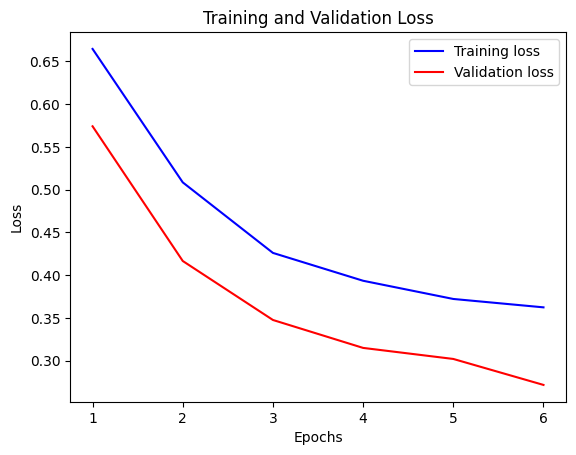

In [ ]:
training_loss = train_history1.history['loss']
validation_loss = train_history1.history['val_loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
for layer in TFModel.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss="binary_crossentropy",
              metrics=["Accuracy", "Recall", "Precision", "AUC"])

tf.profiler.experimental.start('logs/')
start3 = tf.timestamp()
train_history2 = model.fit(
    x = [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    y = Y_train_df.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_encoded['input_ids'], X_valid_encoded['attention_mask']], Y_valid_df.to_numpy()),
    verbose=2,
    callbacks= [early_stopping]
)
end3 = tf.timestamp()
tf.profiler.experimental.stop()
timings3= end3 - start3
print(timings3)

Epoch 1/5
134/134 - 134s - loss: 0.1567 - Accuracy: 0.9346 - recall: 0.9233 - precision: 0.9415 - auc: 0.9853 - val_loss: 0.0878 - val_Accuracy: 0.9680 - val_recall: 0.9592 - val_precision: 0.9734 - val_auc: 0.9944 - 134s/epoch - 1s/step
Epoch 2/5
Restoring model weights from the end of the best epoch: 1.
134/134 - 76s - loss: 0.0787 - Accuracy: 0.9703 - recall: 0.9632 - precision: 0.9758 - auc: 0.9961 - val_loss: 0.0930 - val_Accuracy: 0.9670 - val_recall: 0.9708 - val_precision: 0.9606 - val_auc: 0.9946 - 76s/epoch - 566ms/step
Epoch 2: early stopping
tf.Tensor(209.94610118865967, shape=(), dtype=float64)


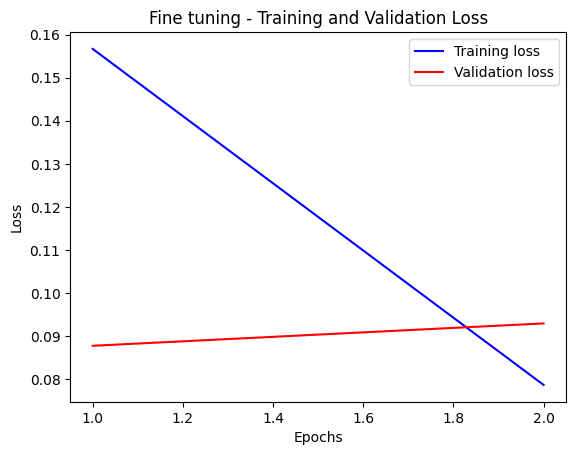

In [ ]:
training_loss2 = train_history2.history['loss']
validation_loss2 = train_history2.history['val_loss']

epochs = range(1, len(training_loss2) + 1)
plt.plot(epochs, training_loss2, 'b', label='Training loss')
plt.plot(epochs, validation_loss2, 'r', label='Validation loss')
plt.title('Fine tuning - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
y_pred = model.predict([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], batch_size=128, verbose=1)
y_pred_class = (y_pred > 0.5).astype(int)
target_names = ['Ham','Spam']

print(classification_report(Y_test_df, y_pred_class,target_names=target_names,digits=4 ))

10/10 [==============================] - 7s 295ms/step
              precision    recall  f1-score   support

         Ham     0.9708    0.9630    0.9669       622
        Spam     0.9603    0.9687    0.9645       575

    accuracy                         0.9657      1197
   macro avg     0.9656    0.9659    0.9657      1197
weighted avg     0.9658    0.9657    0.9658      1197



In [ ]:
print(y_pred_class)

In [ ]:
print(y_pred)

In [ ]:
print('spam' if y_pred [0][0] > 0.5 else 'not spam')

not spam


In [ ]:
model.save('/content/gdrive/My Drive/model/Electra2/',overwrite=True)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
testmodel = tf.saved_model.load('/content/gdrive/My Drive/model/Electra2/')

In [ ]:
tf.profiler.experimental.stop()

In [ ]:
testtokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')
dummyinput = 'Obama Criminal Enterprise Collapsing  https://t.co/zIWjkQNMkh https://t.co/3gkxKiCqgP #TCOT #MAGA #PJNET https://t.co/ie8v1ORvAJ'

def encoder(tokenizer1, text, batch_size=256, max_length=128):
    input_ids_list = []
    attention_mask_list = []
    inputs = tokenizer1(text,
                        max_length=max_length,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_token_type_ids=False
                        )

    input_ids_list.extend(inputs['input_ids'])
    attention_mask_list.extend(inputs['attention_mask'])

    input_ids_tensor = tf.convert_to_tensor(input_ids_list)
    input_ids_tensor = tf.reshape(input_ids_tensor, [1, max_length])
    attention_mask_tensor = tf.convert_to_tensor(attention_mask_list)
    attention_mask_tensor = tf.reshape(attention_mask_tensor, [1, max_length])
    return {
        'input_ids': input_ids_tensor,
        'attention_mask':attention_mask_tensor
    }

def classify_text(dummyinput):
    input = [dummyinput]
    X_predict_encoded = encoder(testtokenizer, dummyinput)
    output = model.predict([X_predict_encoded['input_ids'], X_predict_encoded['attention_mask']], batch_size=64, verbose=0)
    return output

for _ in range(10):
    _ = classify_text(dummyinput)

repetitions = 300
timings = np.zeros((repetitions, 1))

tf.profiler.experimental.start('logs/')
for rep in range(repetitions):
    start = tf.timestamp()
    testing123 = classify_text(dummyinput)
    end = tf.timestamp()
    timings[rep] = end - start
tf.profiler.experimental.stop()

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn*1000)
print(std_syn)

94.1421643892924
0.005313334157426216


In [ ]:
print(sys.getsizeof(testmodel))

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=logs

## Unused code